In [1]:
import dynamicPortfolioAllocation as dpa
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm


ModuleNotFoundError: No module named 'dynamicPortfolioAllocation'

## Import Data and Compute the Paramters of the Uncertainty $\xi_t$

In [2]:
# Import data from Yahoo Finance
stocks = ["NVDA", "NFLX", "SMCI", "AVGO", "MELI", "DXCM", "AMD", "FTNT", "REGN", "LRCX"]
start_date = "2020-01-01"
end_date = "2025-03-31"
data = yf.download(stocks, start=start_date, end=end_date, ignore_tz=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed


In [3]:
# Extract adjusted close prices 
prices = data['Close']
prices = prices.dropna(axis=1)

# Calculate moments of the return distribtuion
returns = prices.pct_change().dropna()
mean_returns = returns.mean().values
cov_returns = returns.cov().values

# Example risk-free rate
r_f = 0.000175

# Set the random seed for reproducibility
np.random.seed(42)

## The Exact DP for a Single Risky Asset 



The opitmal policy $\pi^*_t$ is computed using the formula: 

\begin{align*}
    \pi_{t}^* &=\text{argmax}_{0\leq\pi_{t}\leq1}\quad\mathbb{E}_{\xi_{t+1}}\ln\left[1+r_t+\pi_{t}(\xi_{t+1}-1-r_t)\right]\\
    &\approx\text{argmax}_{0\leq\pi_{t}\leq1}\quad\frac{1}{N}\sum_{j=1}^N\ln\left[1+r_t+\pi_{t}(\xi_{t+1}-1-r_t)\right]
\end{align*}

For a fixed free rate $r_t=r$ and $\xi_t$ iid, the optimal strategy is the constant policy "invest the same proportion of wealth" $\pi_t^{\star}=\pi^{\star}$.

### Illustration

In [ ]:
# Set the parameters of the uncertainty distribution
mean_ret = mean_returns[0]
var = cov_returns[0,0]

pi_star_exact, _ = dpa.pi_star_single_asset(mean_ret, var, r_f, N=int(1e7))
pi_star_exact

0.8574169346169508

### Compute the Value Function

The value function is computed using the formula:
$$
U_t(v)=\ln v + \sum_{k=1}^{T-t}G_k(\pi^*_{T-k})=\ln v + (T-t)G(\pi^*)
$$
where $ $
\begin{align*}
    G(\pi^*)&=\mathbb{E}_{\xi}\ln\left[1+r+\pi^*(\xi-1-r)\right]\\
    &\approx\frac{1}{N}\sum_{j=1}^N\ln\left[1+r+\pi^*(\xi-1-r)\right]
\end{align*}

In [ ]:
V0_exact = dpa.value_func_exact(100, 0, 10, mean_ret, var, r_f, N=int(1e7))
V0_exact

4.599956235358831

### Inspect the Variance of the Optimal Allocation vs. the Number of Samples in the Monte Carlo Simulation

We notice that the estimation of the expectations requires a very large number of Monte Carlo simulations for the allocation in the risky asset to converge to the exact value.

In [ ]:
# Select a rage of sample sizes
n_samples = range(100000,10000000,100000)

# Compute the stationary optimal policy using Monte Carlo simulation
_dp = [dpa.pi_star_single_asset(mean_ret, var, r_f, N) for N in n_samples]
pi_star_mc = [_item[0] for _item in _dp]

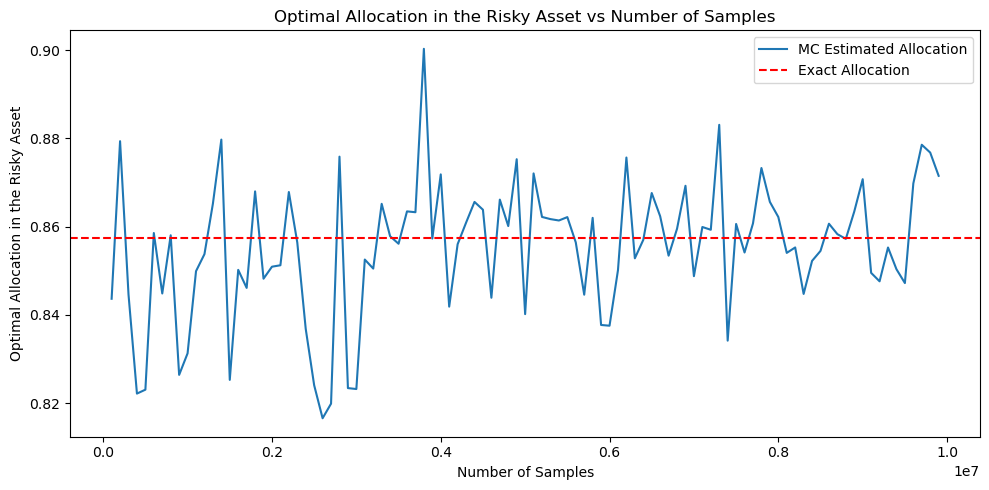

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(n_samples, pi_star_mc, label="MC Estimated Allocation")
plt.axhline(y=pi_star_exact, linestyle='--', color='red', label="Exact Allocation")
plt.xlabel("Number of Samples")
plt.ylabel("Optimal Allocation in the Risky Asset")
plt.title("Optimal Allocation in the Risky Asset vs Number of Samples")
plt.legend()
plt.tight_layout()
plt.show()

## The Exact DP for Multiple Risky Assets


The opitmal policy $\pi^*_t=(\pi^{0*}_t,\dots,\pi^{K*}_t)$ is computed using the formula: 

\begin{align*}
    \pi_{t}^* &=\text{argmax}_{\substack{0\leq\pi^i_{t}\leq1\\\sum \pi^i_t=1}}\quad\mathbb{E}_{\xi_{t+1}}\ln\left[1+\pi^0_tr_t+\sum_{i=1}^K\pi^i_{t}(\xi^i_{t+1}-1)\right]\\
    &\approx\text{argmax}_{\substack{0\leq\pi^i_{t}\leq1\\\sum \pi^i_t=1}}\quad\frac{1}{N}\sum_{j=1}^N\ln\left[1+\pi_{t}\cdot R_t\right]
\end{align*}
where $R_t = [r_t, \xi^1_t-1,\dots,\xi^K_t-1]^{\top}$.

Again, for a fixed free rate $r_t=r$ and $\xi_t$ iid, the optimal strategy is the constant policy "invest the same proportion of wealth" $\pi_t^{\star}=\pi^{\star}$.

### Illustration

In [ ]:
# Compute the stationary policy using the exact method
pi_star, _ = dpa.pi_star(mean_returns, cov_returns, r_f)
pi_star

array([1.59654419e-11, 1.49942620e-10, 4.55138079e-11, 2.60917407e-11,
       1.25202544e-10, 2.76080887e-11, 3.45083351e-11, 2.56172688e-11,
       2.12183075e-01, 1.62415667e-11, 7.87816925e-01])

## The Approximate DP Implementation

In [ ]:
# Estimate the optimal policy
policy, V_approx, v0_grid = dpa.pi_star_single_asset_adp(T=3, v_size=100,v_min=1e-2, v_max=100,  pi_grid=None, 
                                     r_f=r_f, 
                                     mu=mean_ret, 
                                     sigma=np.sqrt(var), 
                                     gamma=1.0,
                                     N=500000)

### Plot the Optimal Allocations for Different Wealth Levels

Notice that the approximate optimal allocations converge to the exact one with increased MC samples. Furthermore, notice that for wealth levels close to the end points of the grid, the allocation in the risky asset yields inaccurate values. This is depicted by the variability of the estimated optimal allocations in the plot below. We are guessing that this is due to the under-representation of $\xi$ trajectories hitting values close to those
ends. 

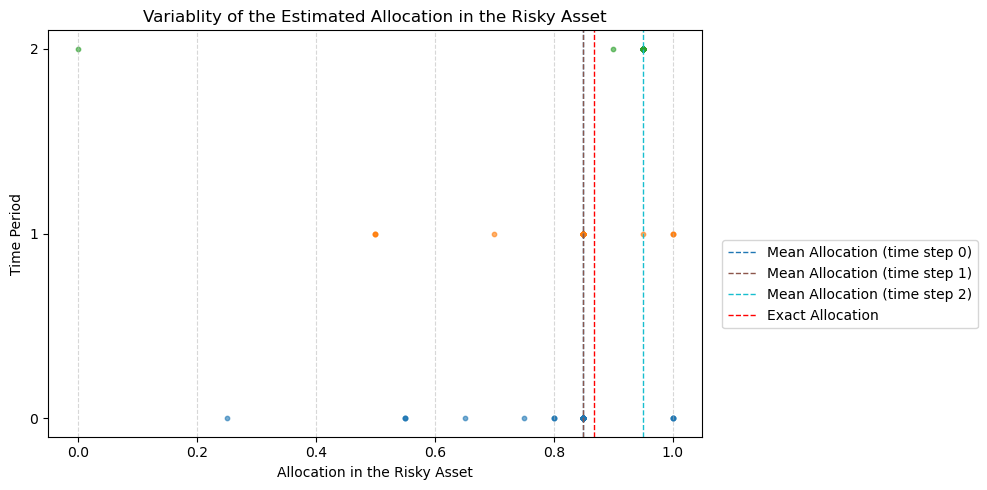

In [ ]:
T, N = policy.shape

# Plot the estimated policy
plt.figure(figsize=(10, 5))
cmap = plt.colormaps['tab10'].resampled(T)
pi_star_exact, _ = ry.pi_star_single_asset(mean_ret, var, r_f)
for t in range(T):
    row = policy[t]
    color = cmap(t)
    y_values = np.full_like(row, fill_value=t)
    plt.scatter(row, y_values, alpha=0.6, s=10)
    row_mean = np.mean(row[25:75]) #avoid underepresented allocations at the end points of the grid interval
    plt.axvline(x=row_mean, linestyle='--', color=color, linewidth=1, label=f"Mean Allocation (time step {t})")



plt.xlabel("Allocation in the Risky Asset")
plt.ylabel("Time Period")
plt.title("Variablity of the Estimated Allocation in the Risky Asset")
plt.yticks(np.arange(T))
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.axvline(x=pi_star_exact, linestyle='--', color='red', linewidth=1, label="Exact Allocation")
plt.legend(bbox_to_anchor=(1.02, 0.5))
plt.tight_layout()
plt.show()

### Compare the Exact Value Function with the Approximate Value Function

In [ ]:
# Evaluate the exact value function
V0 = dpa.value_func_exact(v0_grid, 0, T, mean_ret, var, r_f, N=int(1e7))

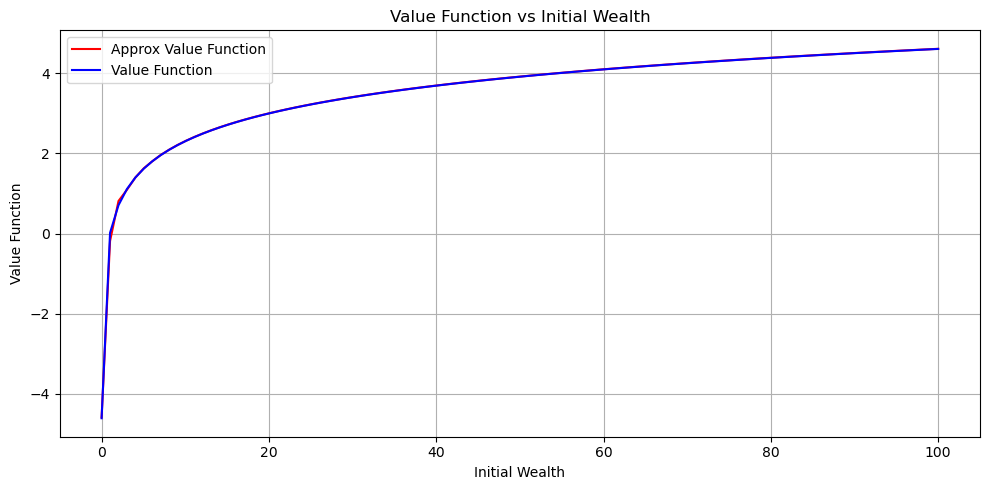

In [17]:
# Plot the results for the exact value function and the approximate value function
plt.figure(figsize=(10, 5))
plt.plot(v0_grid, V_approx(v0_grid), color='red', label="Approx Value Function")
plt.plot(v0_grid, V0, color='blue', label="Value Function")
plt.xlabel("Initial Wealth")
plt.ylabel("Value Function")
plt.title("Value Function vs Initial Wealth")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()